# Init

In [1]:
%matplotlib inline

import csv
import datetime
import itertools
import json
import math
import matplotlib
import time
import logging
import sys
import sqlite3
import os
import random
import warnings

import gensim

import scipy.sparse

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn import random_projection
from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
from scoring import main

In [4]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [5]:
blogcatalog = loadmat('blogcatalog/blogcatalog.mat')

In [6]:
blog_labels = blogcatalog['group']

In [7]:
blog_A = blogcatalog['network']

In [15]:
blog_A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [16]:
N = blog_A.shape[0]

Obtain its transition matrix (note that the input matrix is symmetric):

In [45]:
np.power(scipy.sparse.csc_matrix.sum(blog_A, axis=1), -.7).shape

(10312, 1)

In [ ]:
normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(blog_A, axis=1) ), 0, N, N)

In [17]:
normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(blog_A, axis=1) ), 0, N, N)

In [18]:
blog_trans = normalizer @ blog_A

## Flickr

In [12]:
flickr = loadmat('flickr/flickr.mat')

In [13]:
flickr_A = flickr['network']
flickr_A

<80513x80513 sparse matrix of type '<class 'numpy.float64'>'
	with 11799764 stored elements in Compressed Sparse Column format>

In [14]:
N = flickr_A.shape[0]
N

80513

# Utility Functions

Write the graph to a file as adjacency list:

In [19]:
def sparse2graph(x):
    G = defaultdict(lambda: set())
    cx = x.tocoo()
    for i, j, v in zip(cx.row, cx.col, cx.data):
        G[i].add(j)
    
    lines = []
    for k, v in G.items():
        s = str(k) + ' ' + ' '.join(map(str, v))
        lines.append(s)
    return lines

In [20]:
G = nx.parse_adjlist(sparse2graph(blog_A))

# Random Projection

Iterative computing:

In [22]:
X = np.random.rand(1000, 500)
transformer = random_projection.GaussianRandomProjection(n_components=128, random_state=42)
Y = transformer.fit(X)

In [42]:
Y.components_ = np.power(Y.components_, 0.0)

In [43]:
Z = transformer.transform(X)

In [44]:
Z

array([[244.03780014, 244.03780014, 244.03780014, ..., 244.03780014,
        244.03780014, 244.03780014],
       [251.44771984, 251.44771984, 251.44771984, ..., 251.44771984,
        251.44771984, 251.44771984],
       [246.30937939, 246.30937939, 246.30937939, ..., 246.30937939,
        246.30937939, 246.30937939],
       ...,
       [251.51048624, 251.51048624, 251.51048624, ..., 251.51048624,
        251.51048624, 251.51048624],
       [235.68669296, 235.68669296, 235.68669296, ..., 235.68669296,
        235.68669296, 235.68669296],
       [240.75216462, 240.75216462, 240.75216462, ..., 240.75216462,
        240.75216462, 240.75216462]])

In [33]:
(X @ Y.components_.T)

array([[ 0.01594374, -0.08723125,  2.23954467, ...,  0.46728496,
         0.19606386,  0.30295309],
       [ 0.25341453,  0.37006167,  2.38502913, ...,  0.10697233,
        -0.90758355,  0.18836813],
       [-0.19876407,  1.86306727,  1.59927889, ...,  0.20490529,
         0.4450354 ,  1.06700783],
       ...,
       [ 0.65072992,  1.66044133,  2.94242512, ...,  0.63856823,
        -0.13840223,  1.27547272],
       [ 0.16329823,  0.32064575,  1.87828597, ...,  0.14715746,
        -0.2790416 ,  0.92031721],
       [ 0.0153604 ,  0.81394676,  2.100395  , ..., -0.86000989,
        -0.23318889,  1.37883573]])

In [23]:
Y.components_

array([[ 0.04390374, -0.01222095,  0.05724812, ..., -0.01682372,
        -0.07739445, -0.12222338],
       [ 0.0818633 ,  0.16877018, -0.12361708, ...,  0.05664304,
        -0.05048557,  0.05060965],
       [ 0.12368671,  0.08172684,  0.00527063, ...,  0.10680549,
         0.09051519,  0.05237248],
       ...,
       [-0.00029964,  0.01066886,  0.04304109, ...,  0.00529455,
         0.06324871, -0.12981535],
       [-0.03905845,  0.13112503,  0.08588685, ..., -0.07071537,
         0.08302674,  0.0710103 ],
       [-0.00867485, -0.02404968, -0.19078063, ..., -0.0566236 ,
         0.01439484,  0.11295343]])

In [25]:
Y.components_.shape

(128, 500)

In [64]:
# projection method: choose from Gaussian and Sparse
# input matrix: choose from adjacency and transition matrix
# alpha adjusts the weighting of nodes according to their degree
def randne_projection(A, q=3, dim=128, projection_method='gaussian', input_matrix='adj', alpha=None):
    assert input_matrix == 'adj' or input_matrix == 'trans'
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    if input_matrix == 'adj':
        M = A
    else:
        N = A.shape[0]
        normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(A, axis=1) ), 0, N, N)
        M = normalizer @ A
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)
    Y = transformer.fit(M)
    # Random projection for A
    if alpha is not None:
        Y.components_ = Y.components_ @ spdiags( \
                        np.squeeze(np.power(scipy.sparse.csc_matrix.sum(A, axis=1), alpha)), 0, N, N)
    cur_U = transformer.transform(M)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        cur_U = M @ cur_U
        U_list.append(cur_U)
    return U_list

Brute force computing, designed for the clipped transition matrix (introduced below):

**Shall I use different projection matrices???**

**Why sometimes CSC matrix or CSR matrix returned by randne_projection()???**

In [51]:
def get_clipped_matrices(A, q=3, beta=None):
    M_list = []
    N = A.shape[0]
    normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(A, axis=1) ), 0, N, N)
    trans = normalizer @ A
    trans_pow = trans
    b = beta / N

    for i in range(1, q + 1):
        print ('Current order: ', i)
        _mat = get_grarep_clipped_matrix(trans_pow / trans_pow.sum(axis=0), b)
        M_list.append(_mat)
        # is this going to cause loss of accuracy?
        trans_pow = trans @ trans_pow
    
    return M_list

In [104]:
# takes in pre-computed clipped transition matrices
def randne_projection_bruteforce(M_list, dim=128, projection_method='gaussian'):
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)

    U_list = []
    
    for M in M_list:
        cur_U = transformer.fit_transform(M)
        U_list.append(cur_U)
    return U_list

# Merge Embeddings

Merge embeddings (projections) from different powers of $A$ together:

In [50]:
# When weights is None, concatenate instead of linearly combines the embeddings from different powers of A
def randne_merge(U_list, weights, normalization=False):
    dense_U_list = [_U.todense() for _U in U_list] if type(U_list[0]) == csc_matrix else U_list
    _U_list = [normalize(_U, norm='l2', axis=1) for _U in dense_U_list] if normalization else dense_U_list

    if weights is None:
        return np.concatenate(_U_list, axis=1)
    U = np.zeros_like(_U_list[0])
    for cur_U, weight in zip(_U_list, weights):
        U += cur_U * weight
    return U

## Transition Matrix Power for Flickr

In [118]:
flickr_A

<80513x80513 sparse matrix of type '<class 'numpy.float64'>'
	with 11799764 stored elements in Compressed Sparse Column format>

...But this is going to give us OOM.

# All Variants to be Considered

Here lists all variants that we consider:

1. Different projection matrices: Gaussian and Signed Binary (the sparse one)
2. Different input graph matrices: adjacency matrix and transition matrix and shifted transition matrix (see the GraRep paper -- may also need to tune $\beta$). Also, the shifted transition matrix one requires exact computation of $A^k$.
4. Different weight combinations of different powers: use the recommended weight combination in the paper (or do a grid search here?), and also only $A$, only $A^2$, only $A^3$ and so on. Also use one averaged over all powers of $A$, so that it is comparable to DeepWalk. Or alternatively, just take the concatenation of different embedding vectors.
4. Normalization: do we (L2) normalize the embeddings computed from each power of $A$ or not?

Here are two sample configurations:

In [212]:
conf1 = {
    'projection_method': 'sparse',
    'input_matrix': 'trans',
    'weights': [1.0, 1e2, 1e3, 0, 0, 0],
    'normalization': True,
    'd': 128,
}

conf2 = {
    'projection_method': 'gaussian',
    'input_matrix': 'adj',
    'weights': None,
    'normalization': False,
    'd': 256,
}

Then we generate all possible configurations. First, generate different weights:

In [20]:
max_order = 6
# should it be a mapping between name and configuration?
# using only A^k
weights = [[1.0 if order == chosen_order else 0 for order in range(max_order)] for chosen_order in range(max_order)]
# recommended setting for trans matrix
weights += [ [1.0, 1e2, 1e3, 0, 0, 0] ]
# recommended setting for adj matrix
weights += [ [0.1, 0.001, 0, 0, 0, 0] ]
# DeepWalk style weights
weights += [ [1.0 for _ in range(order)] + [0 for _ in range(max_order - order)] for order in range(2, max_order + 1)]
# no weights, use concatenation instead
weights += [None]
# TODO: grid search on weights?
weights

[[1.0, 0, 0, 0, 0, 0],
 [0, 1.0, 0, 0, 0, 0],
 [0, 0, 1.0, 0, 0, 0],
 [0, 0, 0, 1.0, 0, 0],
 [0, 0, 0, 0, 1.0, 0],
 [0, 0, 0, 0, 0, 1.0],
 [1.0, 100.0, 1000.0, 0, 0, 0],
 [0.1, 0.001, 0, 0, 0, 0],
 [1.0, 1.0, 0, 0, 0, 0],
 [1.0, 1.0, 1.0, 0, 0, 0],
 [1.0, 1.0, 1.0, 1.0, 0, 0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 None]

In [26]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim']

all_dims = [128, 256, 512]

all_conf_raw = itertools.product(
    # projection method
    ['gaussian', 'sparse'],
    # input matrix
    ['adj', 'trans'],
    weights,
    # normalization
    [True, False],
    # dimensionality
    all_dims
)
all_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_conf_raw]
len(all_conf)

336

In [36]:
all_conf[124]

{'projection_method': 'gaussian',
 'input_matrix': 'trans',
 'weights': [1.0, 100.0, 1000.0, 0, 0, 0],
 'normalization': False,
 'dim': 256}

Finally, a wrapper function that takes in a configuration and return the learned embeddings:

In [54]:
max_order=6

In [62]:
# A is the adjacency matrix
def randne_wrapper(A, conf):
#     # avoid redundant computation, but may increase memory usage
#     conf_fingerprint = get_projection_fingerprint(conf)
#     if conf_fingerprint in computed_U_list:
#         U_list = computed_U_list[conf_fingerprint]
#         # print ('Fingerprint found for %s, skip computing the projected matrices.' % conf_fingerprint)
#     else:
        # projection method: choose from Gaussian and Sparse
        # input matrix: choose from adjacency and transition matrix
    U_list = randne_projection(A,
                               q=max_order,
                               # q=len(conf['weights']),
                               dim=conf['dim'],
                               projection_method=conf['projection_method'],
                               input_matrix=conf['input_matrix'],
                               alpha=conf['alpha'],
    )
#     computed_U_list[conf_fingerprint] = U_list

    U = randne_merge(U_list, conf['weights'], conf['normalization'])
    return U

**Reduce Redundant Computation**

Create fingerprints for the projection part:

In [30]:
def get_projection_fingerprint(conf):
    return 'dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix']

**GraRep Style Input Matrix**

We defines a utility function to construct a GraRep style input matrix (see the GraRep paper). In other words, for each element $x$ in the $k$-step transition matrix, we set:
$x^\prime = \max(\log x - \log \beta, 0)$

Note: it is recommended that $\beta$ should be set to $1 / N$.

In [143]:
# takes in a numpy.matrix and return a CSC sparse matrix
def get_grarep_clipped_matrix(A, beta):
    tmp = np.log(A) - np.log(beta) if abs(beta) > eps else np.log(A)
    tmp[np.isneginf(tmp)] = 0
    return csc_matrix(np.clip(tmp, 0, None) )

**Important**: this does not fit into the current RandNE framework, because we have to compute the GraRep clipped input matrix using brute force. Here we first compute the clipped matrices:

In [33]:
all_grarep_conf_raw = itertools.product(
    # projection method
    ['gaussian', 'sparse'],
    # input matrix, just a placeholder
    ['grarep_trans'],
    weights,
    # normalization
    [True, False],
    # dimensionality
    all_dims
)
all_grarep_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_grarep_conf_raw]
len(all_grarep_conf)

168

In [35]:
all_grarep_conf[:3]

[{'projection_method': 'gaussian',
  'input_matrix': 'grarep_trans',
  'weights': [1.0, 0, 0, 0, 0, 0],
  'normalization': True,
  'dim': 128},
 {'projection_method': 'gaussian',
  'input_matrix': 'grarep_trans',
  'weights': [1.0, 0, 0, 0, 0, 0],
  'normalization': True,
  'dim': 256},
 {'projection_method': 'gaussian',
  'input_matrix': 'grarep_trans',
  'weights': [1.0, 0, 0, 0, 0, 0],
  'normalization': True,
  'dim': 512}]

In [134]:
%%time
# this is time-consuming
M_list = get_clipped_matrices(blog_A, q=max_order, beta=1.0)

Current order:  1
Current order:  2
Current order:  3
Current order:  4
Current order:  5
Current order:  6
CPU times: user 2min 40s, sys: 24.6 s, total: 3min 5s
Wall time: 3min 5s


In [135]:
M_list

[<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 628636 stored elements in Compressed Sparse Column format>,
 <10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 26640503 stored elements in Compressed Sparse Column format>,
 <10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 40577753 stored elements in Compressed Sparse Column format>,
 <10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 42191702 stored elements in Compressed Sparse Column format>,
 <10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 48721436 stored elements in Compressed Sparse Column format>,
 <10312x10312 sparse matrix of type '<class 'numpy.float64'>'
 	with 48158669 stored elements in Compressed Sparse Column format>]

In [150]:
def get_debug_clipped_matrices(A, q=3):
    M_list = []
    N = A.shape[0]
    normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(A, axis=1) ), 0, N, N)
    trans = normalizer @ A
    trans_pow = trans

    for i in range(1, q + 1):
        print ('Current order: ', i)
        _mat = trans_pow / trans_pow.sum(axis=0)
        M_list.append(_mat)
        # is this going to cause loss of accuracy?
        trans_pow = trans @ trans_pow
    
    return M_list

In [151]:
%time raw_M_list = get_debug_clipped_matrices(blog_A, q=6)

Current order:  1
Current order:  2
Current order:  3
Current order:  4
Current order:  5
Current order:  6
CPU times: user 1min 59s, sys: 10.6 s, total: 2min 9s
Wall time: 2min 9s


In [157]:
N = blog_A.shape[0]
N

10312

In [158]:
1.0 / N

9.69743987587277e-05

In [159]:
raw_M_list[2][random.randint(0, N)]

matrix([[9.80433119e-05, 6.60055616e-05, 8.56702079e-05, ...,
         4.80185629e-05, 2.84748514e-05, 3.48066188e-05]])

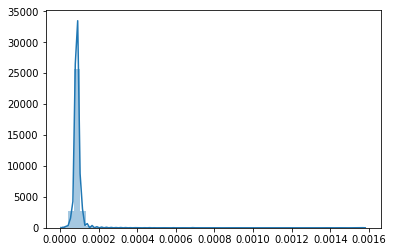

In [163]:
sns.distplot(raw_M_list[3][random.randint(0, N)])

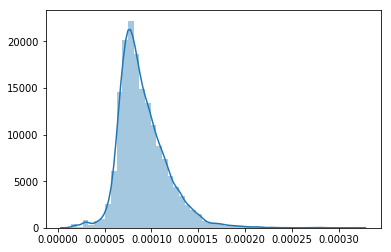

In [164]:
sns.distplot(raw_M_list[3][random.randint(0, N)])

/home/local_hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


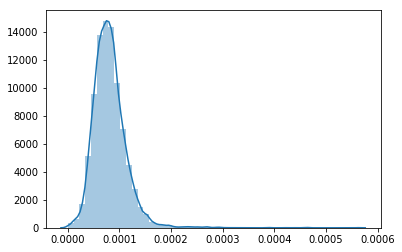

In [160]:
sns.distplot(raw_M_list[2][random.randint(0, N)])

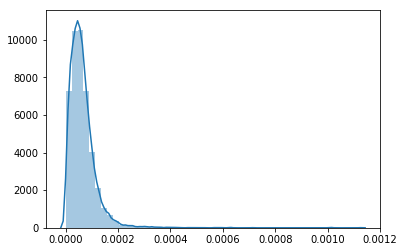

In [161]:
sns.distplot(raw_M_list[2][random.randint(0, N)])

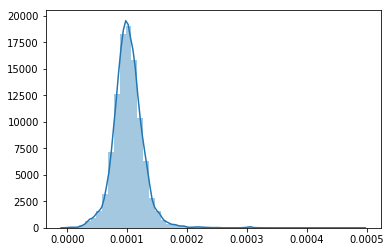

In [162]:
sns.distplot(raw_M_list[2][random.randint(0, N)])

# Grid Search on all Hyperparameters

Define the embedding file's name based on the hyperparameters:

In [56]:
def get_emb_filename(prefix, conf):
    return prefix + '-dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix'] + ',normalization=' + str(conf['normalization']) \
        + ',weights=' + (','.join(map(str, conf['weights'])) if conf['weights'] is not None else 'None') \
        + ',alpha=' + (str(conf['alpha']) if 'alpha' in conf else '') \
        + '.mat'

In [345]:
get_emb_filename('data/blog', all_conf[1])

'data/blog-dim=256,projection_method=gaussian,input_matrix=adj,normalization=True,weights=1.0,0,0,0,0,0.mat'

We start with non-clipped input matrices:

In [419]:
all_conf[246]

{'projection_method': 'sparse',
 'input_matrix': 'adj',
 'weights': None,
 'normalization': True,
 'dim': 128}

In [ ]:
INF = 1000

df = pd.DataFrame()

prefix = 'data/blog'

computed_U_list = {}
# for conf in [all_conf[21]]:
for conf in all_conf[246:]:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A, conf, computed_U_list)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = main(
        ["--emb", emb_filename,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('data/blog-scores.txt', sep='\t', index=False, header=True)

df

data/blog-dim=128,projection_method=sparse,input_matrix=adj,normalization=True,weights=None.mat
data/blog-dim=256,projection_method=sparse,input_matrix=adj,normalization=True,weights=None.mat
data/blog-dim=512,projection_method=sparse,input_matrix=adj,normalization=True,weights=None.mat
data/blog-dim=128,projection_method=sparse,input_matrix=adj,normalization=False,weights=None.mat
data/blog-dim=256,projection_method=sparse,input_matrix=adj,normalization=False,weights=None.mat
data/blog-dim=512,projection_method=sparse,input_matrix=adj,normalization=False,weights=None.mat
data/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-dim=256,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=False,weights=1.0,0,0,0,

## Grid Search For the Clipped Matrix

In [52]:
df = pd.DataFrame()

prefix = 'data/blog-clipped-'

computed_U_list = {}
# for conf in [all_conf[21]]:
for conf in all_grarep_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U_list = randne_projection_bruteforce(M_list,
                                          dim=conf['dim'],
                                          projection_method=conf['projection_method']
        )
        U = randne_merge(U_list, conf['weights'], conf['normalization'])
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = main(
        ["--emb", emb_filename,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('data/blog-clipped-scores.txt', sep='\t', index=False, header=True)

df

data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=512,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=512,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,0,0,0,0,0.mat
data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=0,1.0,0,0,0,0.mat
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=0,1.0,0,0,0,0.m

data/blog-clipped--dim=512,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,1.0,1.0,0,0.mat
data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=512,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=512,projection_method=gaussian,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,1.0,1.0,1.0,0.mat
data/blog-clipped--dim=128,projection_method=gaussian,input_matrix=

data/blog-clipped--dim=256,projection_method=sparse,input_matrix=grarep_trans,normalization=False,weights=0.1,0.001,0,0,0,0.mat
data/blog-clipped--dim=512,projection_method=sparse,input_matrix=grarep_trans,normalization=False,weights=0.1,0.001,0,0,0,0.mat
data/blog-clipped--dim=128,projection_method=sparse,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,0,0,0,0.mat
data/blog-clipped--dim=256,projection_method=sparse,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,0,0,0,0.mat
data/blog-clipped--dim=512,projection_method=sparse,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,0,0,0,0.mat
data/blog-clipped--dim=128,projection_method=sparse,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,0,0,0,0.mat
data/blog-clipped--dim=256,projection_method=sparse,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,0,0,0,0.mat
data/blog-clipped--dim=512,projection_method=sparse,input_matrix=grarep_trans,normalization=False,weights=1.0,1.0,0,0

,dim,input_matrix,macro,micro,normalization,projection_method,weights
0,128.0,grarep_trans,0.064746,0.202720,1.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
1,256.0,grarep_trans,0.072206,0.223535,1.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
2,512.0,grarep_trans,0.078131,0.242786,1.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
3,128.0,grarep_trans,0.079958,0.140119,0.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
4,256.0,grarep_trans,0.095880,0.160715,0.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
5,512.0,grarep_trans,0.108898,0.191647,0.0,gaussian,"[1.0, 0, 0, 0, 0, 0]"
6,128.0,grarep_trans,0.109869,0.287898,1.0,gaussian,"[0, 1.0, 0, 0, 0, 0]"
7,256.0,grarep_trans,0.126100,0.308021,1.0,gaussian,"[0, 1.0, 0, 0, 0, 0]"
8,512.0,grarep_trans,0.131767,0.323166,1.0,gaussian,"[0, 1.0, 0, 0, 0, 0]"
9,128.0,grarep_trans,0.121665,0.202284,0.0,gaussian,"[0, 1.0, 0, 0, 0, 0]"


## Grid Search for Degree Normalization

In [66]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim', 'alpha']

all_dims = [512]
all_alphas = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]

all_alpha_conf_raw = itertools.product(
    # projection method
    ['gaussian'],
    # input matrix
    ['trans'],
    # weights
    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
    # normalization
    [True],
    # dimensionality
    all_dims,
    # alpha
    all_alphas,
)
all_alpha_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_alpha_conf_raw]
len(all_alpha_conf)

11

In [67]:
INF = 1000

df = pd.DataFrame()

prefix = 'data/blog'
for conf in all_alpha_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = main(
        ["--emb", emb_filename,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('data/blog-alpha-scores.txt', sep='\t', index=False, header=True)

df

data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=0.0.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.1.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.2.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.3.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.4.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.5.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,alpha=-0.6.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=

,alpha,dim,input_matrix,macro,micro,normalization,projection_method,weights
0,0.0,512.0,trans,0.163171,0.340862,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
1,-0.1,512.0,trans,0.176493,0.345119,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,-0.2,512.0,trans,0.183254,0.349579,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,-0.3,512.0,trans,0.188535,0.352779,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,-0.4,512.0,trans,0.191326,0.351421,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
5,-0.5,512.0,trans,0.192004,0.349399,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
6,-0.6,512.0,trans,0.192297,0.349952,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
7,-0.7,512.0,trans,0.198824,0.349179,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
8,-0.8,512.0,trans,0.194016,0.346253,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
9,-0.9,512.0,trans,0.192969,0.342341,1.0,gaussian,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


Do another grid search for the right weight combination:

In [85]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim', 'alpha']

all_dims = [512]
all_alphas = [-0.7]

all_alpha_conf_raw = itertools.product(
    # projection method
    ['gaussian'],
    # input matrix
    ['trans'],
    # weights
    [
#         [1.0, 2.0, 5.0, 0, 0, 0],
#         [1.0, 2.0, 10.0, 0, 0, 0],
#         [1.0, 4.0, 10.0, 0, 0, 0],
#         [1.0, 2.0, 10.0, 5.0, 0, 0],
#         [1.0, 2.0, 10.0, 20.0, 0, 0],
#         [0.0, 2.0, 10.0, 20.0, 0, 0],
        [0.0, 0.0, 10.0, 20.0, 0, 0],
        [0, 0, 0, 10, 0, 0],
        [0, 0, 0, 20, 0, 0],
        [0, 0, 0, 0, 10, 0, 0],
        [0, 0, 0, 0, 20, 0, 0],
        # [0.0, 0.0, 1.0, 2.0, 0, 0],
        # [0.0, 0.0, 1.0, 0.0, 0, 0],
        # [0.0, 0.0, 0.0, 1.0, 0, 0]
    ],
    # normalization
    [True, False],
    # dimensionality
    all_dims,
    # alpha
    all_alphas,
)
all_alpha_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_alpha_conf_raw]
len(all_alpha_conf)

10

In [86]:
INF = 1000

df = pd.DataFrame()

prefix = 'data/blog'
for conf in all_alpha_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = main(
        ["--emb", emb_filename,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('data/blog-alpha-weights-scores.txt', sep='\t', index=False, header=True)

df

data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=0.0,0.0,10.0,20.0,0,0,alpha=-0.7.mat
File data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=0.0,0.0,10.0,20.0,0,0,alpha=-0.7.mat already exists, skipped.
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=False,weights=0.0,0.0,10.0,20.0,0,0,alpha=-0.7.mat
File data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=False,weights=0.0,0.0,10.0,20.0,0,0,alpha=-0.7.mat already exists, skipped.
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=0,0,0,10,0,0,alpha=-0.7.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=False,weights=0,0,0,10,0,0,alpha=-0.7.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,normalization=True,weights=0,0,0,20,0,0,alpha=-0.7.mat
data/blog-dim=512,projection_method=gaussian,input_matrix=trans,norm

,alpha,dim,input_matrix,macro,micro,normalization,projection_method,weights
0,-0.7,512.0,trans,0.217455,0.349403,1.0,gaussian,"[0.0, 0.0, 10.0, 20.0, 0, 0]"
1,-0.7,512.0,trans,0.025213,0.165139,0.0,gaussian,"[0.0, 0.0, 10.0, 20.0, 0, 0]"
2,-0.7,512.0,trans,0.189683,0.352604,1.0,gaussian,"[0, 0, 0, 10, 0, 0]"
3,-0.7,512.0,trans,0.025455,0.165661,0.0,gaussian,"[0, 0, 0, 10, 0, 0]"
4,-0.7,512.0,trans,0.212433,0.362058,1.0,gaussian,"[0, 0, 0, 20, 0, 0]"
5,-0.7,512.0,trans,0.025221,0.163535,0.0,gaussian,"[0, 0, 0, 20, 0, 0]"
6,-0.7,512.0,trans,0.128054,0.310242,1.0,gaussian,"[0, 0, 0, 0, 10, 0, 0]"
7,-0.7,512.0,trans,0.025225,0.164832,0.0,gaussian,"[0, 0, 0, 0, 10, 0, 0]"
8,-0.7,512.0,trans,0.164345,0.341927,1.0,gaussian,"[0, 0, 0, 0, 20, 0, 0]"
9,-0.7,512.0,trans,0.026165,0.169984,0.0,gaussian,"[0, 0, 0, 0, 20, 0, 0]"


# Grid Search for the Shift Factor $\beta$

In [84]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim', 'beta']

all_dims = [256]
all_betas = [0.0, 0.25, 0.5, 1.0, 2.0, 4.0]

all_beta_conf_raw = itertools.product(
    # projection method
    ['gaussian', 'sparse'],
    # input matrix
    ['grarep_trans'],
    # weights
    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
    # normalization
    [True],
    # dimensionality
    all_dims,
    # beta
    all_betas
)
all_beta_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_beta_conf_raw]
len(all_beta_conf)

12

In [ ]:
df = pd.DataFrame()

prefix = 'data/blog-clipped-'

# for conf in [all_conf[21]]:
for conf in all_beta_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        M_list = get_clipped_matrices(blog_A, q=max_order, beta=conf['beta'])
        U_list = randne_projection_bruteforce(M_list,
                                          dim=conf['dim'],
                                          projection_method=conf['projection_method']
        )
        U = randne_merge(U_list, conf['weights'], conf['normalization'])
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = main(
        ["--emb", emb_filename,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('data/blog-clipped-beta-scores.txt', sep='\t', index=False, header=True)

df

data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,beta=0.0.mat
Current order:  1
Current order:  2
Current order:  3
Current order:  4
Current order:  5
Current order:  6
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,beta=0.25.mat
Current order:  1
Current order:  2
Current order:  3
Current order:  4
Current order:  5
Current order:  6
data/blog-clipped--dim=256,projection_method=gaussian,input_matrix=grarep_trans,normalization=True,weights=1.0,1.0,1.0,1.0,1.0,1.0,beta=0.5.mat
Current order:  1
Current order:  2
Current order:  3
Current order:  4


# Result Analysis

## Degree Normalization

In [ ]:
%%time
conf = {'projection_method': 'gaussian',
 'input_matrix': 'adj',
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'normalization': True,
 'dim': 512}
U_list = randne_projection_bruteforce(M_list,
                                          dim=conf['dim'],
                                          projection_method=conf['projection_method']
        )
U = randne_merge(U_list, conf['weights'], conf['normalization'])

### Speed

In [60]:
%%time
conf = {'projection_method': 'gaussian',
 'input_matrix': 'adj',
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'normalization': True,
 'dim': 512}
U_list = randne_projection_bruteforce(M_list,
                                          dim=conf['dim'],
                                          projection_method=conf['projection_method']
        )
U = randne_merge(U_list, conf['weights'], conf['normalization'])

CPU times: user 1min 15s, sys: 1.32 s, total: 1min 16s
Wall time: 1min 16s


In [62]:
%%time
conf = {'projection_method': 'sparse',
 'input_matrix': 'adj',
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'normalization': True,
 'dim': 512}
U_list = randne_projection_bruteforce(M_list,
                                          dim=conf['dim'],
                                          projection_method=conf['projection_method']
        )
U = randne_merge(U_list, conf['weights'], conf['normalization'])

CPU times: user 4.03 s, sys: 439 ms, total: 4.47 s
Wall time: 4.48 s


In [63]:
fname = 'data/test-blog-clipped-randne.mat'
savemat(fname, {'emb': U})

In [64]:
%%time
f1_scores = main(
        ["--emb", fname,
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"],
        )

CPU times: user 22.3 s, sys: 34.9 s, total: 57.3 s
Wall time: 13.4 s


In [65]:
f1_scores

defaultdict(float, {'micro': 0.3645590165508944, 'macro': 0.2212518517493617})

### Performance

In [53]:
df = pd.read_csv('data/blog-clipped-scores.txt', sep='\t')

In [55]:
df = df[['input_matrix', 'projection_method', 'dim', \
                                 'normalization', 'weights', 'macro', 'micro']]
df = df.sort_values(by=['macro'], ascending=False)
df.head(n=20)

,input_matrix,projection_method,dim,normalization,weights,macro,micro
74,grarep_trans,gaussian,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.228530,0.369396
158,grarep_trans,sparse,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.228014,0.368204
152,grarep_trans,sparse,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0]",0.223781,0.369928
146,grarep_trans,sparse,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 0, 0]",0.223197,0.367086
68,grarep_trans,gaussian,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0]",0.221217,0.372582
62,grarep_trans,gaussian,512.0,1.0,"[1.0, 1.0, 1.0, 1.0, 0, 0]",0.219385,0.369821
73,grarep_trans,gaussian,256.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.217817,0.355091
157,grarep_trans,sparse,256.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.214089,0.354158
151,grarep_trans,sparse,256.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0]",0.211126,0.356187
61,grarep_trans,gaussian,256.0,1.0,"[1.0, 1.0, 1.0, 1.0, 0, 0]",0.210925,0.353826


# Node Classification on Blogcatalog

## RandNE

Learn embeddings with the recommended configuration (trans matrix + recommended weights):

In [19]:
%%time
weights = list(map(lambda x: 0.01 * x, [1e2, 1e4, 1e5]))
U_list_fast = randne_projection(blog_trans, q=3, dim=128)
U_fast = randne_merge(U_list_fast, weights)

CPU times: user 238 ms, sys: 52.2 ms, total: 290 ms
Wall time: 290 ms


In [20]:
U_fast

array([[-0.48844904,  0.20275235, -0.4192839 , ..., -1.11367325,
        -4.4354135 , -1.8893595 ],
       [-1.52668501,  3.5871983 ,  0.85047499, ..., -1.22756421,
        -4.41966455, -1.55155192],
       [-0.44574345,  0.4061968 , -0.65713982, ..., -0.58740916,
        -4.95153347, -1.93410333],
       ...,
       [-1.41488359,  0.69459542, -1.08402925, ..., -1.40729178,
        -5.16958445, -2.06114091],
       [-2.5628838 ,  1.10293738, -2.63083881, ..., -0.99083508,
        -7.72526503, -1.04238015],
       [-3.67204472,  0.33042499,  4.1620681 , ..., -4.04393533,
        -9.70169837, -4.83837598]])

In [21]:
savemat('data/blog-trans-fast.mat', {'emb': U_fast})

Run classification:

0.1740621209024954
CPU times: user 14.8 s, sys: 21.9 s, total: 36.7 s
Wall time: 9.96 s


## GraRep

A nice answer on truncated SVD in Python: https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn

In [20]:
from sparsesvd import sparsesvd
from scipy.sparse import csc_matrix

In [34]:
%%time
ut, s, vt = sparsesvd(blog_A, 128)

CPU times: user 3.22 s, sys: 30 ms, total: 3.25 s
Wall time: 3.24 s


For reference, here is the GraRep implementation: https://github.com/ShelsonCao/GraRep/blob/master/code/core/GetProbTranMat.m

In [164]:
def get_svd_emb(A, d):
    ut, s, vt = sparsesvd(A, d)
    return np.matmul(ut.T, np.diag(s ** 0.5) )

def grarep(A, q=3, d=128, beta=None):
    U_list = []
    
    N = A.shape[0]
    if beta is None:
        beta = 1.0 / N
    normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(blog_A, axis=1) ), 0, N, N)
    trans = normalizer @ A
    trans_pow = trans
    
    for i in range(1, q + 1):
        print ('Current order: ', i)
        _mat = get_grarep_clipped_matrix(trans_pow / trans_pow.sum(axis=0), beta)
        _cur_U = get_svd_emb(_mat, d)
        U_list.append(_cur_U)
        # is this going to cause loss of accuracy?
        trans_pow = trans @ trans_pow
    return U_list

In [150]:
x = np.asarray([[0, 1], [2, 3]])
y = np.log(x)
y[np.isneginf(y)] = 0
y

/home/local_hcchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([[0.        , 0.        ],
       [0.69314718, 1.09861229]])

In [165]:
%time U_list = grarep(blog_A, q=6)

Current order:  1


/home/local_hcchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Current order:  2
Current order:  3
Current order:  4
Current order:  5
Current order:  6
CPU times: user 7min 45s, sys: 48.7 s, total: 8min 34s
Wall time: 8min 9s


In [166]:
U = np.concatenate(U_list, axis=1)
U.shape

(10312, 768)

In [169]:
savemat('data/blog-grarep-q=6.mat', {'emb': U})

Or alternatively, normalize before concatenation:

In [196]:
U_list_norm = [normalize(_U, norm='l2', axis=1) for _U in U_list]
U_norm = np.concatenate(U_list_norm, axis=1)
U_norm.shape

(10312, 768)

In [202]:
savemat('data/blog-grarep-q=6-norm.mat', {'emb': U_norm})

Then run classification:

In [189]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "data/blog-grarep-q=6.mat",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"])

Results, using embeddings of dimensionality 768
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.37347736152608596, 'macro': 0.2239223887022614}
Shuffle #2:      {'micro': 0.3574182603331277, 'macro': 0.21202142126653475}
Shuffle #3:      {'micro': 0.3666153846153846, 'macro': 0.21850897139673947}
Shuffle #4:      {'micro': 0.3614652127169405, 'macro': 0.21702878391208905}
Shuffle #5:      {'micro': 0.3688215850564994, 'macro': 0.2154206458435744}
Average score: {'micro': 0.36555956084960767, 'macro': 0.2173804422242398}
-------------------
CPU times: user 30.7 s, sys: 53.7 s, total: 1min 24s
Wall time: 15.3 s


For the original MATLAB GraRep implementation:

In [ ]:
cd /home/local_hcchen/ws/GraRep/code/core
matlab
load('/home/local_hcchen/ws/deepwalk/example_graphs/blogcatalog.mat')
# should take about 5 minutes
tic; U = GraRep(network, 3, 128, false); toc
save('/home/local_hcchen/ws/large-network-embeddings/blogcatalog/grarep-steps=3-norm=false.mat', 'U')

Normalization!!!

In [181]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "/home/local_hcchen/ws/large-network-embeddings/blogcatalog/grarep-steps=3-norm=false.mat",
          "--network","/home/local_hcchen/ws/large-network-embeddings/blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"])

Results, using embeddings of dimensionality 384
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.36686162844389725, 'macro': 0.2175807549452131}
Shuffle #2:      {'micro': 0.3672969455714613, 'macro': 0.21246681498005252}
Shuffle #3:      {'micro': 0.36046422258089306, 'macro': 0.2191963041617719}
Shuffle #4:      {'micro': 0.36952849024727386, 'macro': 0.21639958480866647}
Shuffle #5:      {'micro': 0.36678944137507674, 'macro': 0.21061840465392065}
Average score: {'micro': 0.3661881456437205, 'macro': 0.21525237270992492}
-------------------


In [182]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "/home/local_hcchen/ws/large-network-embeddings/blogcatalog/grarep-steps=3.mat",
          "--network","/home/local_hcchen/ws/large-network-embeddings/blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"])

Results, using embeddings of dimensionality 384
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.38673312883435584, 'macro': 0.23039458041463504}
Shuffle #2:      {'micro': 0.38405351376287866, 'macro': 0.22862059986057068}
Shuffle #3:      {'micro': 0.37781868384721584, 'macro': 0.22020741182804598}
Shuffle #4:      {'micro': 0.3930960252171907, 'macro': 0.23724224031936236}
Shuffle #5:      {'micro': 0.38105117565698476, 'macro': 0.21206827600585948}
Average score: {'micro': 0.38455050546372516, 'macro': 0.22570662168569472}
-------------------


In [185]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "/home/local_hcchen/ws/large-network-embeddings/blogcatalog/grarep-steps=6-norm=false.mat",
          "--network","/home/local_hcchen/ws/large-network-embeddings/blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"])

Results, using embeddings of dimensionality 768
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.3662305867951955, 'macro': 0.21994083650761226}
Shuffle #2:      {'micro': 0.3685823754789272, 'macro': 0.22101012232390843}
Shuffle #3:      {'micro': 0.3730311179408375, 'macro': 0.22665150849111165}
Shuffle #4:      {'micro': 0.36857866850956, 'macro': 0.22044264381551862}
Shuffle #5:      {'micro': 0.36790936232105953, 'macro': 0.23083254539261516}
Average score: {'micro': 0.3688664222091159, 'macro': 0.2237755313061532}
-------------------


In [186]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "/home/local_hcchen/ws/large-network-embeddings/blogcatalog/grarep-steps=6.mat",
          "--network","/home/local_hcchen/ws/large-network-embeddings/blogcatalog/blogcatalog.mat",
          "--num-shuffles", "5"])

Results, using embeddings of dimensionality 768
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.3789691670501611, 'macro': 0.23489610360269006}
Shuffle #2:      {'micro': 0.3867208464310358, 'macro': 0.2315061374628617}
Shuffle #3:      {'micro': 0.3784530386740331, 'macro': 0.23274557954971678}
Shuffle #4:      {'micro': 0.37847809377402, 'macro': 0.2296160308062376}
Shuffle #5:      {'micro': 0.3832321524629217, 'macro': 0.23184508517220584}
Average score: {'micro': 0.38117065967843433, 'macro': 0.2321217873187424}
-------------------


## DeepWalk

And run classification for DeepWalk:

In [70]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "~/ws/deepwalk/example_graphs/blogcatalog.embeddings",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.34998850486627325, 'macro': 0.20068161161471323}
Average score: {'micro': 0.34998850486627325, 'macro': 0.20068161161471323}
-------------------
CPU times: user 3.15 s, sys: 5.17 s, total: 8.32 s
Wall time: 1.77 s


And for DeepWalk:

In [65]:
y_dw, preds_dw, indices_test_dw = main(
        ["--emb", "~/ws/deepwalk/example_graphs/blogcatalog.embeddings",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.357416781714987, 'macro': 0.21307696569035764}
Average score: {'micro': 0.357416781714987, 'macro': 0.21307696569035764}
-------------------


/home/hcchen/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
